In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import Levenshtein
from rouge_score import rouge_scorer

PATH = "./data/openai_humaneval/humaneval_completed.jsonl"
df = pd.read_json(PATH, lines=True)

print("Loaded:", df.shape)
df.head(2)

Loaded: (20, 14)


,task_id,prompt,canonical_solution,test,entry_point,prompt_original,prompt_low,prompt_high,codet5_solution_original,codet5_solution_low,codet5_solution_high,deepseek_solution_original,deepseek_solution_low,deepseek_solution_high
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...",has_close_elements,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\ndef has_close_eleme...,from typing import List\n\ndef has_close_eleme...,for i in range(len(numbers) - 1):\n ...,for i in range(len(arg0)):\n for j ...,for i in range(len(arg0)):\n ...,for i in range(len(numbers)):\n for...,return False\n,return False\n
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups,from typing import List\n\n\ndef separate_pare...,from typing import List\n\ndef separate_paren_...,from typing import List\n\ndef separate_paren_...,"paren_string = paren_string.replace(' ', '...",paren_groups = []\n paren_stack = []\n ...,paren_stack = []\n paren_list =...,paren_stack = []\n paren_list = []\n ...,# TODO: Write your code here\n pass\n,"assert separate_paren_groups(""(a)"") == [""a..."


## Experimental setup and evaluation metrics

We evaluate the privacy–utility trade-off for code completion on a subset of 20 tasks from the *openai_humaneval* benchmark. For each task, we construct three prompt variants:

- **Original**: the unmodified HumanEval prompt.
- **Low obfuscation**: variable renaming and light syntactic perturbations.
- **High obfuscation**: aggressive anonymization (placeholders), removal of comments and doctests.

For each prompt variant, we generate code completions using two different models:
- **CodeT5+ 2B** (sequence-to-sequence, instruction-oriented),
- **DeepSeek-Coder 1.3B** (causal language model trained on large-scale code corpora).

We evaluate each completion using two complementary metrics:

- **Utility**: ROUGE-L F1 score between the generated solution and the canonical HumanEval solution.
- **Privacy**: normalized Levenshtein distance between the obfuscated prompt and the original prompt.

Higher privacy scores correspond to stronger obfuscation, while higher utility scores indicate better functional similarity to the reference solution.

In [11]:
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)

def rougeL_f1(pred: str, ref: str) -> float:
    pred = "" if pred is None else str(pred)
    ref  = "" if ref is None else str(ref)
    return scorer.score(ref, pred)["rougeL"].fmeasure

def norm_levenshtein(a: str, b: str) -> float:
    a = "" if a is None else str(a)
    b = "" if b is None else str(b)
    denom = max(len(a), len(b), 1)
    return Levenshtein.distance(a, b) / denom

In [12]:
def make_long_table(df: pd.DataFrame, model_name: str, col_prefix: str) -> pd.DataFrame:
    """
    model_name: label for plots ("codet5", "deepseek")
    col_prefix: prefix for solution columns, e.g.
        codet5_solution_original / low / high
        deepseek_solution_original / low / high
    """
    rows = []
    for _, r in df.iterrows():
        for level, prompt_col, sol_col in [
            ("original", "prompt_original", f"{col_prefix}_original"),
            ("low",      "prompt_low",      f"{col_prefix}_low"),
            ("high",     "prompt_high",     f"{col_prefix}_high"),
        ]:
            rows.append({
                "task_id": r.get("task_id", None),
                "entry_point": r.get("entry_point", None),
                "model": model_name,
                "obfuscation": level,
                "prompt": r[prompt_col],
                "prompt_original": r["prompt_original"],
                "completion": r.get(sol_col, ""),
                "canonical_solution": r["canonical_solution"],
            })
    return pd.DataFrame(rows)

# adjust prefixes if your column names differ
codet5_long   = make_long_table(df, "CodeT5+ 2B",   "codet5_solution")
deepseek_long = make_long_table(df, "DeepSeek 1.3B", "deepseek_solution")

long_df = pd.concat([codet5_long, deepseek_long], ignore_index=True)
print("Long table:", long_df.shape)  # should be 20 * 3 * 2 = 120
long_df.head()

Long table: (120, 8)


,task_id,entry_point,model,obfuscation,prompt,prompt_original,completion,canonical_solution
0,HumanEval/0,has_close_elements,CodeT5+ 2B,original,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\n\ndef has_close_ele...,for i in range(len(numbers) - 1):\n ...,"for idx, elem in enumerate(numbers):\n ..."
1,HumanEval/0,has_close_elements,CodeT5+ 2B,low,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,for i in range(len(arg0)):\n for j ...,"for idx, elem in enumerate(numbers):\n ..."
2,HumanEval/0,has_close_elements,CodeT5+ 2B,high,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,for i in range(len(arg0)):\n ...,"for idx, elem in enumerate(numbers):\n ..."
3,HumanEval/1,separate_paren_groups,CodeT5+ 2B,original,from typing import List\n\n\ndef separate_pare...,from typing import List\n\n\ndef separate_pare...,"paren_string = paren_string.replace(' ', '...",result = []\n current_string = []\n ...
4,HumanEval/1,separate_paren_groups,CodeT5+ 2B,low,from typing import List\n\ndef separate_paren_...,from typing import List\n\n\ndef separate_pare...,paren_groups = []\n paren_stack = []\n ...,result = []\n current_string = []\n ...


In [13]:
long_df["privacy"] = long_df.apply(lambda r: 0.0 if r["obfuscation"] == "original" else norm_levenshtein(r["prompt_original"], r["prompt"]), axis=1)

long_df["utility_rougeL"] = long_df.apply(lambda r: rougeL_f1(r["completion"], r["canonical_solution"]), axis=1)

long_df.groupby(["model", "obfuscation"])[["privacy", "utility_rougeL"]].mean()

privacy  utility_rougeL
model         obfuscation                          
CodeT5+ 2B    high         0.388592        0.356426
              low          0.053561        0.393039
              original     0.000000        0.476290
DeepSeek 1.3B high         0.388592        0.281945
              low          0.053561        0.263230
              original     0.000000        0.420935

**We can already see that the CodeT5 outperforms the DeepSeek model in this task**

## Privacy–utility trade-off per model

The figures above show the relationship between privacy (x-axis) and utility (y-axis) for CodeT5+ 2B and DeepSeek-Coder 1.3B, evaluated across original, low-obfuscation, and high-obfuscation prompts.

### CodeT5+ 2B

For CodeT5+ 2B, utility is highest on the original prompts and gradually decreases as obfuscation increases. Notably, this degradation is relatively smooth: low obfuscation leads to only a modest reduction in utility, while high obfuscation results in a more pronounced but still non-catastrophic decline.

This behavior is consistent with the architectural and training design of CodeT5 and its extensions. CodeT5 is a sequence-to-sequence Transformer trained to jointly model natural language and programming languages, with an explicit focus on tasks such as code summarization, generation from docstrings, and code translation  
([Wang et al., 2021](https://arxiv.org/abs/2109.00859)).  
CodeT5+ further scales this paradigm with larger models and instruction-style tuning, strengthening its reliance on semantic alignment between textual descriptions and code.

As a result, CodeT5+ relies heavily on high-level semantic cues present in docstrings and function signatures, rather than memorization of canonical algorithmic templates. When variable names are renamed or lightly obfuscated, these semantic cues remain partially intact, allowing the model to reconstruct a reasonable implementation. However, under aggressive obfuscation—where comments, examples, and descriptive identifiers are removed—the semantic bridge between intent and implementation weakens, leading to a gradual loss in utility.

Importantly, the smooth degradation suggests that CodeT5+ exhibits a degree of robustness to surface-level obfuscation, trading peak accuracy for stability under privacy-preserving transformations.

---

### DeepSeek-Coder 1.3B

DeepSeek-Coder 1.3B exhibits a qualitatively different pattern. On original prompts, it achieves high utility and frequently produces solutions that closely match canonical HumanEval implementations. However, under obfuscation—particularly high obfuscation—the utility drops more sharply compared to CodeT5+.

This sensitivity can be attributed to DeepSeek-Coder’s training regime as a causal language model optimized for large-scale code continuation. Rather than explicitly learning a mapping from natural language intent to code, DeepSeek-Coder learns to predict the next tokens in code given extensive contextual exposure to real-world repositories. This makes the model highly effective when familiar algorithmic patterns, naming conventions, and structural cues are present.

When these cues are removed through obfuscation, the model’s ability to anchor generation to known templates is significantly impaired. Consequently, while DeepSeek-Coder achieves higher peak utility on unprotected prompts, it pays a larger utility cost when privacy-preserving transformations disrupt its learned code priors.

This trade-off highlights a fundamental tension: models optimized for faithful reproduction of canonical code patterns are also more vulnerable to obfuscation-based privacy defenses  
([DeepSeek-AI, 2024](https://arxiv.org/abs/2401.06066)).

---

### Summary

Overall, these results demonstrate that the privacy–utility trade-off in code completion is strongly model-dependent. Sequence-to-sequence, instruction-oriented models such as CodeT5+ degrade more gracefully under obfuscation, while high-capacity causal code models such as DeepSeek-Coder achieve higher utility on original prompts but are more sensitive to privacy-preserving transformations.

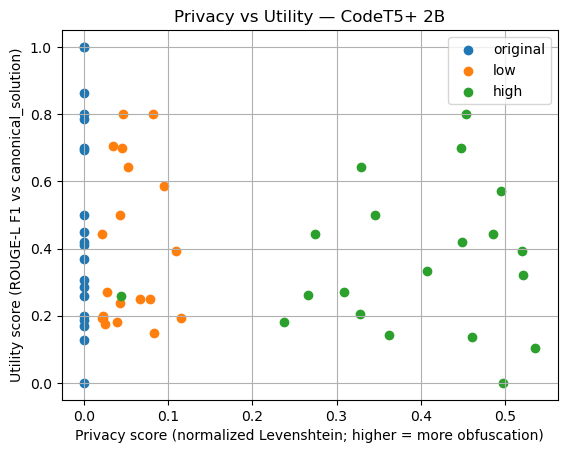

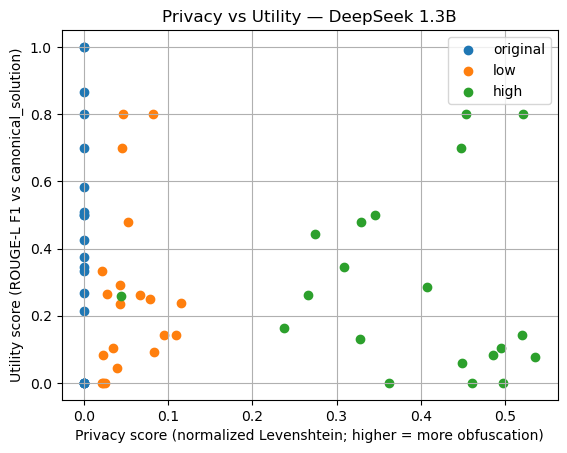

In [22]:
def plot_model_scatter(long_df: pd.DataFrame, model_name: str):
    d = long_df[long_df["model"] == model_name].copy()

    # plot by obfuscation level
    for level in ["original", "low", "high"]:
        dd = d[d["obfuscation"] == level]
        plt.scatter(dd["privacy"], dd["utility_rougeL"], label=level)

    plt.xlabel("Privacy score (normalized Levenshtein; higher = more obfuscation)")
    plt.ylabel("Utility score (ROUGE-L F1 vs canonical_solution)")
    plt.title(f"Privacy vs Utility — {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_scatter(long_df, "CodeT5+ 2B")
plot_model_scatter(long_df, "DeepSeek 1.3B")

## Cross-model comparison

The combined scatter plot highlights systematic differences between CodeT5+ 2B and DeepSeek-Coder 1.3B across all prompt variants.

DeepSeek-Coder generally occupies the upper region of the utility axis for original prompts, indicating superior performance when the task description closely resembles canonical training examples. In contrast, CodeT5+ shows more conservative but stable performance across increasing privacy levels.

As obfuscation increases, the distributions diverge: DeepSeek-Coder points shift downward more abruptly, while CodeT5+ points remain more evenly spread. This suggests that models with stronger code priors and memorization of common algorithmic templates are more vulnerable to obfuscation-based privacy defenses.

From a privacy-preserving perspective, this behavior is desirable: obfuscation effectively limits the ability of powerful code models to reconstruct sensitive or canonical implementations, thereby reducing potential information leakage.

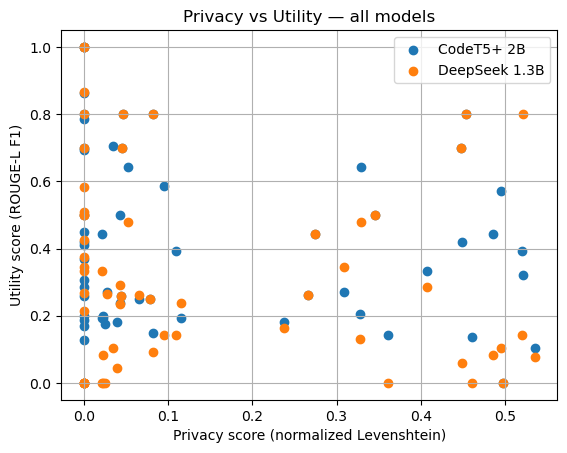

In [18]:
for model_name in long_df["model"].unique():
    d = long_df[long_df["model"] == model_name]
    plt.scatter(d["privacy"], d["utility_rougeL"], label=model_name)

plt.xlabel("Privacy score (normalized Levenshtein)")
plt.ylabel("Utility score (ROUGE-L F1)")
plt.title("Privacy vs Utility — all models")
plt.legend()
plt.grid(True)
plt.show()

## Quantitative summary and final analysis

The table below reports mean privacy and utility scores across models and obfuscation levels. Several trends are evident:

1. **Utility decreases monotonically with increasing obfuscation** for both models, confirming the expected privacy–utility trade-off.
2. **CodeT5+ 2B** exhibits a smaller utility drop from original to high obfuscation (≈0.12 ROUGE-L) compared to **DeepSeek-Coder 1.3B** (≈0.14 ROUGE-L).
3. Both models experience comparable privacy levels under high obfuscation, indicating that the prompt transformations themselves are model-agnostic.

These results suggest that while DeepSeek-Coder achieves higher accuracy on unprotected prompts, it is more sensitive to privacy-preserving transformations. Conversely, CodeT5+ trades peak performance for greater robustness to obfuscation.

From a broader perspective, this aligns with prior work on CodeT5, which emphasizes instruction-following and semantic abstraction, and with recent observations that large causal code models tend to reproduce canonical solutions when sufficient lexical and structural cues are present.

In practice, this implies that privacy-preserving prompt transformations can be an effective defense against unintended memorization or leakage in high-capacity code models, albeit at a measurable cost in utility.

In [19]:
summary = (long_df
           .groupby(["model", "obfuscation"])
           .agg(
               n=("utility_rougeL", "count"),
               privacy_mean=("privacy", "mean"),
               privacy_std=("privacy", "std"),
               utility_mean=("utility_rougeL", "mean"),
               utility_std=("utility_rougeL", "std"),
           )
           .reset_index()
          )

summary

,model,obfuscation,n,privacy_mean,privacy_std,utility_mean,utility_std
0,CodeT5+ 2B,high,20,0.388592,0.123928,0.356426,0.211539
1,CodeT5+ 2B,low,20,0.053561,0.030243,0.393039,0.232496
2,CodeT5+ 2B,original,20,0.000000,0.000000,0.476290,0.301727
3,DeepSeek 1.3B,high,20,0.388592,0.123928,0.281945,0.260196
4,DeepSeek 1.3B,low,20,0.053561,0.030243,0.263230,0.250578
5,DeepSeek 1.3B,original,20,0.000000,0.000000,0.420935,0.332877


In [20]:
def tradeoff_drop(model_name: str):
    d = long_df[long_df["model"] == model_name]
    u_orig = d[d["obfuscation"] == "original"]["utility_rougeL"].mean()
    u_high = d[d["obfuscation"] == "high"]["utility_rougeL"].mean()
    p_high = d[d["obfuscation"] == "high"]["privacy"].mean()
    return {
        "model": model_name,
        "utility_drop_orig_to_high": u_orig - u_high,
        "avg_high_privacy": p_high
    }

pd.DataFrame([tradeoff_drop(m) for m in long_df["model"].unique()])

,model,utility_drop_orig_to_high,avg_high_privacy
0,CodeT5+ 2B,0.119864,0.388592
1,DeepSeek 1.3B,0.138990,0.388592
